In [1]:
import os
from typing import TypedDict, Optional

from dotenv import load_dotenv
load_dotenv()

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage  # adjust import path if needed
from langgraph.graph import StateGraph, START, END
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import InMemorySaver

# 1. LLM setup
def get_groq_llm() -> ChatOpenAI:
    return ChatOpenAI(
        model="openai/gpt-oss-20b",
        base_url="https://api.groq.com/openai/v1",
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.7,
        max_tokens=2000
    )

llm = get_groq_llm()

In [2]:


# 2. Define State schema
class PostState(TypedDict, total=False):
    info: dict                     # input information for the post (topic, tone, audience, key points, etc)
    draft: str                     # current draft of LinkedIn post
    human_feedback: Optional[str]  # feedback from human reviewer
    approved: bool                 # whether human reviewer approved
    final_post: Optional[str]      # final approved post content


In [3]:

# 3. Node: Generate initial draft
def generate_draft(state: PostState) -> dict:
    info = state["info"]
    # Build prompt based on info
    prompt = f"""You are writing a LinkedIn post. Here is the info:
Topic: {info.get('topic')}
Key points: {info.get('key_points')}
Tone: {info.get('tone')}
Audience: {info.get('audience')}

Write a LinkedIn-style post (1-2 short paragraphs) with that info."""
    response = llm.invoke([HumanMessage(content=prompt)])
    draft = response.content.strip()
    print("=== AI Generated Draft ===")
    print(draft)
    return {"draft": draft, "approved": False}

# 4. Node: Ask human reviewer for feedback/approval
def ask_for_feedback(state: PostState) -> dict:
    print("\n--- PAUSING FOR HUMAN REVIEW ---")
    print("Draft to review:")
    print(state["draft"])
    # Use interrupt to pause and wait for human input
    feedback = interrupt("Please review the draft. Provide feedback (or type 'approved' if OK):")
    # Determine approval based on exact word (you may refine logic)
    approved = (feedback.strip().lower() == "approved")
    return {"human_feedback": feedback, "approved": approved}

# 5. Node: Decide next step
# def decide_next(state: PostState) -> Command:
#     if state.get("approved"):
#         return Command(goto="post_to_linkedin")
#     else:
#         return Command(goto="revise_draft")


def decide_next(state: PostState) -> str:
    if state.get("approved", False):
        return "approved"
    else:
        return "revise"


# 6. Node: Revise draft based on feedback
def revise_draft(state: PostState) -> dict:
    feedback = state["human_feedback"] or ""
    old_draft = state["draft"]
    prompt = f"""You are rewriting a LinkedIn post. Original draft:
{old_draft}

Feedback from reviewer:
{feedback}

Revise the draft accordingly (keeping same tone and audience) and output the improved post."""
    response = llm.invoke([HumanMessage(content=prompt)])
    new_draft = response.content.strip()
    print("=== AI Revised Draft ===")
    print(new_draft)
    return {"draft": new_draft, "approved": False}

# 7. Node: Post to LinkedIn (stub)
def post_to_linkedin(state: PostState) -> dict:
    final = state["draft"]
    # Here you would make the real LinkedIn API call.
    # e.g. linkedin_client.post_update(final)
    print("=== POSTING TO LINKEDIN ===")
    print(final)
    # After posting, you can set final_post
    return {"final_post": final}



In [4]:
# 8. Build the workflow graph
def build_workflow_graph() -> StateGraph:
    builder = StateGraph(PostState)

    builder.add_node("generate_draft", generate_draft)
    builder.add_node("ask_for_feedback", ask_for_feedback)
    builder.add_node("revise_draft", revise_draft)
    builder.add_node("post_to_linkedin", post_to_linkedin)

    # Define edges
    builder.add_edge(START, "generate_draft")
    # builder.add_edge("generate_draft", "ask_for_feedback")
    # builder.add_conditional_edges('ask_for_feedback', decide_next, {'approved': 'post_to_linkedin', 'needs_improvement': 'revise_draft'})
    # builder.add_edge('revise_draft', 'ask_for_feedback')
    # builder.add_edge("post_to_linkedin", END)

    builder.add_edge("generate_draft", "ask_for_feedback")
    builder.add_conditional_edges(
        "ask_for_feedback",
        decide_next,
        {"approved": "post_to_linkedin", "revise": "revise_draft"}
    )
    builder.add_edge("revise_draft", "ask_for_feedback")
    builder.add_edge("post_to_linkedin", END)

    # Compile with checkpointing to support interrupt/resume
    graph = builder.compile(checkpointer=InMemorySaver())
    return graph



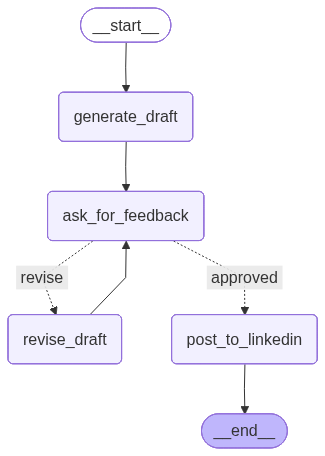

In [5]:
graph= build_workflow_graph()
graph

In [6]:
# 9. Usage / Execution
if __name__ == "__main__":
    # Example input info
    input_info = {
        "topic": "Data Science Workflow Automation with LangGraph",
        "key_points": "human-in-the-loop, agentic workflow, LinkedIn posts, brand voice",
        "tone": "professional yet friendly",
        "audience": "data scientists and AI practitioners on LinkedIn"
    }

    initial_state: PostState = {
        "info": input_info,
        "draft": "",
        "human_feedback": None,
        "approved": False,
        "final_post": None
    }

    graph = build_workflow_graph()
    thread_id = "linkedin_post_thread_1"
    config = {"configurable": {"thread_id": thread_id}}

    # Start workflow
    result = graph.invoke(initial_state, config=config)
    # When it hits interrupt (in ask_for_feedback), you'll need to resume manually:
    # For example:
    #   graph.invoke(Command(resume="Looks great, approve"), config=config)
    #
    # In a real UI setup you'd capture human input & call resume programmatically.

    print("\nWorkflow ended. Final state:")
    print(graph.get_state(config))


=== AI Generated Draft ===
🚀 **Data Science Workflow Automation with LangGraph**  
In today’s fast‑paced analytics landscape, keeping a tight loop between human insight and automated pipelines is more critical than ever. LangGraph’s agentic workflow engine lets you stitch together data ingestion, model training, evaluation, and deployment—while keeping the human in the loop for validation, bias checks, and creative decision‑making. The result? Faster, more reliable experiments that still respect the nuanced judgment only a domain expert can bring.

💡 Whether you’re building a production‑ready model or experimenting with a new feature, LangGraph turns your entire pipeline into a single, extensible graph that’s easy to monitor, debug, and share—right from the same platform that powers our LinkedIn posts. Curious how to integrate this into your team’s workflow? Drop a comment or DM me—let’s chat about making your data science practice both smarter and more human‑centric.

--- PAUSING FOR 

## Manual resume:

In [7]:
if __name__ == "__main__":
    input_info = {
        "topic": "Data Science Workflow Automation with LangGraph",
        "key_points": "human-in-the-loop, agentic workflow, LinkedIn posts, brand voice",
        "tone": "professional yet friendly",
        "audience": "data scientists and AI practitioners on LinkedIn"
    }

    initial_state: PostState = {
        "info": input_info,
        "draft": "",
        "human_feedback": None,
        "approved": False,
        "final_post": None
    }

    graph = build_workflow_graph()
    thread_id = "linkedin_post_thread_manual"
    config = {"configurable": {"thread_id": thread_id}}

    

In [8]:
# Step 1: Start generation (no human input yet)
result = graph.invoke(initial_state, config=config)
print("=== After first invoke (draft generation) ===")
print(graph.get_state(config))



=== AI Generated Draft ===
🚀 Exciting news for data science teams! With LangGraph, you can build **agentic workflows** that automate the heavy lifting—data ingestion, feature engineering, model training—while keeping a **human‑in‑the‑loop** at every critical decision point. This means your models stay robust, auditable, and aligned with business goals, all without sacrificing speed.

💡 Whether you’re drafting LinkedIn posts to showcase your latest insights or refining a production pipeline, LangGraph’s modular approach lets you iterate quickly, embed domain expertise, and maintain that brand voice that resonates with your audience. Ready to turn your data science workflow into a semi‑autonomous, high‑performance engine? Let’s chat! #DataScience #AI #LangGraph #WorkflowAutomation #HumanInTheLoop

--- PAUSING FOR HUMAN REVIEW ---
Draft to review:
🚀 Exciting news for data science teams! With LangGraph, you can build **agentic workflows** that automate the heavy lifting—data ingestion, fea

In [9]:
# Step 2: Pause at human review
state = graph.get_state(config)
interrupts = getattr(state, "interrupts", None) or []
if not interrupts:
    print("⚠️ Unexpected: no interrupt was raised for human review.")
else:
    for intr in interrupts:
        print(f"Interrupt ID: {intr.id}, prompt: {intr.value}")

    # Ask human for feedback
    human_answer = input("Enter feedback or type ‘approve’: ")

    # Step 3: Resume workflow with human feedback
    result2 = graph.invoke(Command(resume={interrupts[0].id: human_answer}), config=config)
    print("=== After resume with human feedback ===")
    print(graph.get_state(config))



Interrupt ID: 2c1a126030d106631d69eced69a74602, prompt: Please review the draft. Provide feedback (or type 'approved' if OK):

--- PAUSING FOR HUMAN REVIEW ---
Draft to review:
🚀 Exciting news for data science teams! With LangGraph, you can build **agentic workflows** that automate the heavy lifting—data ingestion, feature engineering, model training—while keeping a **human‑in‑the‑loop** at every critical decision point. This means your models stay robust, auditable, and aligned with business goals, all without sacrificing speed.

💡 Whether you’re drafting LinkedIn posts to showcase your latest insights or refining a production pipeline, LangGraph’s modular approach lets you iterate quickly, embed domain expertise, and maintain that brand voice that resonates with your audience. Ready to turn your data science workflow into a semi‑autonomous, high‑performance engine? Let’s chat! #DataScience #AI #LangGraph #WorkflowAutomation #HumanInTheLoop
=== AI Revised Draft ===
🚀 **Big news for da

In [10]:
# Step 4: Check if approved. If not, ask human for next step or loop.
final_state = graph.get_state(config)
print("\n--- Final State Check ---")
print(final_state)



--- Final State Check ---
StateSnapshot(values={'info': {'topic': 'Data Science Workflow Automation with LangGraph', 'key_points': 'human-in-the-loop, agentic workflow, LinkedIn posts, brand voice', 'tone': 'professional yet friendly', 'audience': 'data scientists and AI practitioners on LinkedIn'}, 'draft': '🚀 **Big news for data‑science squads!**  \nWith LangGraph you can craft **agentic workflows** that automate the heavy lifting—data ingestion, feature engineering, model training—while keeping a **human‑in‑the‑loop** at every critical decision point. The result? Models that stay robust, auditable, and perfectly aligned with your business goals—without sacrificing speed.\n\n💡 **What’s new?**  \n- **Advanced Map‑Reduce**: Seamlessly split and aggregate massive datasets across multiple agents, speeding up preprocessing and training.  \n- **Multi‑Agentic Systems**: Deploy independent agents that collaborate, compete, or specialize, turning your pipeline into a dynamic, self‑optimizing

In [11]:
# Feedback you got from human
feedback_value = "approved"

# Use the interrupt ID from the snapshot: e.g., "527d0f000978e04a698659d87dddb60d"
resume_command = Command(resume={ "c44836a3bac74aa07e08a8246e520827": feedback_value })

# Invoke the graph to resume
result = graph.invoke(resume_command, config=config)

# Then check the updated state
state_after = graph.get_state(config)
print("State after resuming:", state_after)



--- PAUSING FOR HUMAN REVIEW ---
Draft to review:
🚀 **Big news for data‑science squads!**  
With LangGraph you can craft **agentic workflows** that automate the heavy lifting—data ingestion, feature engineering, model training—while keeping a **human‑in‑the‑loop** at every critical decision point. The result? Models that stay robust, auditable, and perfectly aligned with your business goals—without sacrificing speed.

💡 **What’s new?**  
- **Advanced Map‑Reduce**: Seamlessly split and aggregate massive datasets across multiple agents, speeding up preprocessing and training.  
- **Multi‑Agentic Systems**: Deploy independent agents that collaborate, compete, or specialize, turning your pipeline into a dynamic, self‑optimizing ecosystem.  
- **Modular Design**: Plug in domain expertise or brand‑specific rules at any stage, iterate fast, and keep that voice that resonates with your audience.

Whether you’re drafting LinkedIn posts to showcase your latest insights or refining a production 

## Automatic Loop Resume:

In [12]:
# 9. Automatic loop execution
if __name__ == "__main__":
    input_info = {
        "topic": "Data Science Workflow Automation with LangGraph",
        "key_points": "human-in-the-loop, agentic workflow, LinkedIn posts, brand voice",
        "tone": "professional yet friendly",
        "audience": "data scientists and AI practitioners on LinkedIn"
    }

    initial_state: PostState = {
        "info": input_info,
        "draft": "",
        "human_feedback": None,
        "approved": False,
        "final_post": None
    }

    graph = build_workflow_graph()
    thread_id = "linkedin_post_thread_1"
    config = {"configurable": {"thread_id": thread_id}}

    # Invoke the workflow
    graph.invoke(initial_state, config=config)

    # Loop for human input until workflow ends
    while True:
        state = graph.get_state(config)
        interrupts = getattr(state, "interrupts", None) or []
        if not interrupts:
            # Workflow done
            break

        for intr in interrupts:
            prompt = intr.value if hasattr(intr, "value") else str(intr)
            print(f"\n[Interrupt prompt] {prompt}")
            answer = input("Your answer: ")
            graph.invoke(Command(resume={intr.id: answer}), config=config)

    # Final state
    final_state = graph.get_state(config)
    print("\nWorkflow completed. Final state:")
    print(final_state)

=== AI Generated Draft ===
🚀 **Revolutionizing Data Science Workflows with LangGraph**  
I’m excited to share how LangGraph is turning the traditional data science pipeline into an *agentic workflow* that keeps the human touch front and center. By weaving a human‑in‑the‑loop into every stage—data ingestion, feature engineering, model training, and deployment—LangGraph lets us automate repetitive tasks while preserving the intuition and expertise that only a seasoned data scientist brings.  

🔄 Instead of a static script, we now have a dynamic, conversational workflow that can pause for your insights, ask clarifying questions, and adapt on the fly. This hybrid approach not only speeds up experimentation but also ensures that the final models stay aligned with business goals. If you’re looking to elevate your projects from code‑heavy to *code‑smart*, let’s chat about how LangGraph can fit into your stack. #DataScience #AI #Automation #LangGraph #HumanInTheLoop 🌟

--- PAUSING FOR HUMAN RE

## Real Posting

In [13]:
# linkedin_langgraph_workflow.py
import os
from typing import TypedDict, Optional, Dict, Any

from dotenv import load_dotenv
load_dotenv()

import requests

# LLM / LangChain imports (matches your environment)
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import InMemorySaver

# -------------------------
# 1) LLM setup (Groq)
# -------------------------
def get_groq_llm() -> ChatOpenAI:
    return ChatOpenAI(
        model="openai/gpt-oss-20b",
        base_url="https://api.groq.com/openai/v1",
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.7,
        max_tokens=2000
    )

llm = get_groq_llm()

# -------------------------
# 2) Environment (LinkedIn)
# -------------------------
LINKEDIN_ACCESS_TOKEN = os.getenv("LINKEDIN_ACCESS_TOKEN")
LINKEDIN_AUTHOR_URN = os.getenv("LINKEDIN_AUTHOR_URN")  # e.g., urn:li:person:yyotj6wNOM
# Optional: allow passing token/urn at runtime from config if needed.

# -------------------------
# 3) Workflow state schema
# -------------------------
class PostState(TypedDict, total=False):
    info: dict
    draft: str
    human_feedback: Optional[str]
    approved: bool
    final_post: Optional[str]
    post_id: Optional[str]
    post_error: Optional[str]

# -------------------------
# 4) Nodes: generate / revise / feedback / decide / post
# -------------------------
def generate_draft(state: PostState) -> dict:
    info = state["info"]
    prompt = f"""You are writing a LinkedIn post. Here is the input:
Topic: {info.get('topic')}
Key points: {info.get('key_points')}
Tone: {info.get('tone')}
Audience: {info.get('audience')}

Write a LinkedIn-style post (1-2 short paragraphs) in plain human voice suitable for posting on LinkedIn. Do NOT mention brands unless instructed."""
    response = llm.invoke([HumanMessage(content=prompt)])
    draft = response.content.strip()
    print("\n=== AI Generated Draft ===\n", draft)
    return {"draft": draft, "approved": False}

def ask_for_feedback(state: PostState) -> dict:
    print("\n--- PAUSING FOR HUMAN REVIEW ---")
    print("Draft:\n", state.get("draft", ""))
    # interrupt returns human input when resumed via Command(resume={...})
    feedback = interrupt("Please review the draft. Provide feedback (or type 'approved' if OK):")
    approved = (feedback.strip().lower() == "approved")
    return {"human_feedback": feedback, "approved": approved}

def decide_next(state: PostState) -> str:
    # return routing key
    if state.get("approved", False):
        return "approved"
    return "revise"

def revise_draft(state: PostState) -> dict:
    feedback = state.get("human_feedback") or ""
    old_draft = state.get("draft", "")
    prompt = f"""You are rewriting a LinkedIn post. Original draft:
{old_draft}

Reviewer feedback:
{feedback}

Revise the draft accordingly (keeping same tone and audience). Output only the revised post text."""
    response = llm.invoke([HumanMessage(content=prompt)])
    new_draft = response.content.strip()
    print("\n=== AI Revised Draft ===\n", new_draft)
    return {"draft": new_draft, "approved": False}

def post_to_linkedin_real(state: PostState) -> Dict[str, Any]:
    """
    Posts final draft to LinkedIn using env vars LINKEDIN_ACCESS_TOKEN and LINKEDIN_AUTHOR_URN.
    Returns dict updates for the state: final_post, post_id on success OR post_error on failure.
    """
    token = LINKEDIN_ACCESS_TOKEN
    author_urn = LINKEDIN_AUTHOR_URN
    draft = state.get("draft", "")

    if not token:
        err = "Missing LINKEDIN_ACCESS_TOKEN in environment"
        print("ERROR:", err)
        return {"post_error": err}

    if not author_urn:
        err = "Missing LINKEDIN_AUTHOR_URN in environment"
        print("ERROR:", err)
        return {"post_error": err}

    url = "https://api.linkedin.com/rest/posts"
    headers = {
        "Authorization": f"Bearer {token}",
        "LinkedIn-Version": "202511",
        "X-Restli-Protocol-Version": "2.0.0",
        "Content-Type": "application/json",
    }
    body = {
        "author": author_urn,
        "commentary": draft,
        "visibility": "PUBLIC",
        "distribution": {
            "feedDistribution": "MAIN_FEED",
            "targetEntities": [],
            "thirdPartyDistributionChannels": []
        },
        "lifecycleState": "PUBLISHED",
        "isReshareDisabledByAuthor": False
    }

    try:
        resp = requests.post(url, headers=headers, json=body, timeout=20)
    except Exception as e:
        err = f"HTTP request error: {e}"
        print("ERROR:", err)
        return {"post_error": err}

    print("LinkedIn response status:", resp.status_code)
    try:
        data = resp.json()
    except Exception:
        data = {"raw": resp.text}
    print("LinkedIn response body:", data)

    if resp.status_code >= 200 and resp.status_code < 300:
        # success — try to extract post id
        post_id = data.get("id") or data.get("URN") or resp.headers.get("x-restli-id") or None
        return {"final_post": draft, "post_id": post_id}
    else:
        # include more error info in state
        error_message = data if isinstance(data, (str, dict)) else str(data)
        return {"post_error": f"Status {resp.status_code}: {error_message}"}



In [14]:
# -------------------------
# 5) Build StateGraph
# -------------------------
def build_workflow_graph() -> StateGraph:
    builder = StateGraph(PostState)

    builder.add_node("generate_draft", generate_draft)
    builder.add_node("ask_for_feedback", ask_for_feedback)
    builder.add_node("revise_draft", revise_draft)
    builder.add_node("post_to_linkedin", post_to_linkedin_real)

    builder.add_edge(START, "generate_draft")
    builder.add_edge("generate_draft", "ask_for_feedback")

    # conditional edges: decide_next returns "approved" or "revise"
    builder.add_conditional_edges(
        "ask_for_feedback",
        decide_next,
        {"approved": "post_to_linkedin", "revise": "revise_draft"}
    )

    builder.add_edge("revise_draft", "ask_for_feedback")
    builder.add_edge("post_to_linkedin", END)

    graph = builder.compile(checkpointer=InMemorySaver())
    return graph



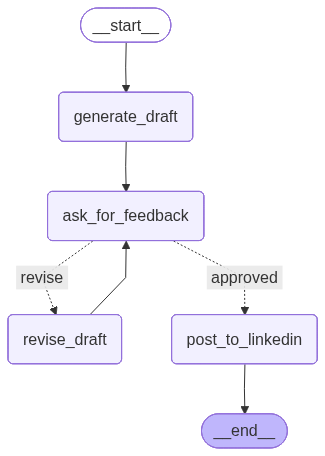

In [15]:
graph = build_workflow_graph()
graph

In [16]:
# -------------------------
# 6) Automatic run (CLI) — loops on interrupts until done
# -------------------------
def run_workflow_auto(initial_info: dict, thread_id: str = "linkedin_post_thread_1"):
    initial_state: PostState = {
        "info": initial_info,
        "draft": "",
        "human_feedback": None,
        "approved": False,
        "final_post": None,
        "post_id": None,
        "post_error": None
    }

    graph = build_workflow_graph()
    config = {"configurable": {"thread_id": thread_id}}

    # Kick off graph execution (it will run until first interrupt)
    graph.invoke(initial_state, config=config)

    # Loop until no interrupts (workflow ended)
    while True:
        state = graph.get_state(config)
        interrupts = getattr(state, "interrupts", None) or []
        if not interrupts:
            break

        # There may be one interrupt (ask_for_feedback) — prompt user and resume
        for intr in interrupts:
            prompt = intr.value if hasattr(intr, "value") else str(intr)
            print(f"\n[HUMAN REVIEW PROMPT] {prompt}")
            # Collect human input from CLI
            answer = input("Enter feedback (or 'approve'): ").strip()
            # resume with mapping
            graph.invoke(Command(resume={intr.id: answer}), config=config)

    # Final state after workflow completion
    final_state = graph.get_state(config)
    print("\n=== Workflow finished. Final state ===")
    print(final_state)
    return final_state

# -------------------------
# 7) Example usage
# -------------------------
if __name__ == "__main__":
    example_info = {
        "topic": "Data Science Workflow Automation with LangGraph",
        "key_points": "human-in-the-loop, agentic workflow, LinkedIn posts, brand voice",
        "tone": "professional yet friendly",
        "audience": "data scientists and AI practitioners on LinkedIn"
    }

    run_workflow_auto(example_info)



=== AI Generated Draft ===
 🚀 **Streamlining the data science lifecycle with LangGraph**  
If you’ve ever felt bogged down by repetitive data‑prep, model‑tuning, or reporting steps, you’re not alone. LangGraph lets you build *agentic workflows* that automatically orchestrate these tasks while keeping a human in the loop for sanity checks, hyper‑parameter tweaks, and final decision‑making. Think of it as a smart, modular pipeline that “learns” which steps to execute and when to pause for your expert input—so you spend less time on boilerplate and more time on insight.

🔄 **Why this matters for the LinkedIn community**  
For data scientists and AI practitioners, a well‑structured workflow isn’t just a productivity win—it’s a reproducibility win. By embedding human oversight into every critical juncture, LangGraph helps guard against drift, bias, and unexpected outcomes. The result? Faster iteration cycles, cleaner collaboration across teams, and a clearer audit trail that’s perfect for 